<a href="https://colab.research.google.com/github/zeynep68/deep_learning/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import *
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

Using TensorFlow backend.


In [0]:
class CIFAR10():
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = keras.datasets.cifar10.load_data()

        self.width = self.x_train.shape[1]
        self.height = self.x_train.shape[2]
        self.depth = self.x_train.shape[3]
        
        self.num_classes = np.max(self.y_train) + 1
        
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        
        self.y_train = to_categorical(self.y_train, self.num_classes)
        self.y_test = to_categorical(self.y_test, self.num_classes)

        self.scaler = StandardScaler()    

    def get_train_set(self):
        return self.x_train, self.y_train
    
    def get_test_set(self):
        return self.x_test, self.y_test

    def normalize_data(self):
        self.scaler.fit(self.x_train.reshape(-1, 1024))
    
        self.x_train = self.scaler.transform(self.x_train.reshape(-1, 1024))
        self.x_test = self.scaler.transform(self.x_test.reshape(-1,1024))

        self.x_train = self.x_train.reshape((self.train_size, self.width, self.height, self.depth))
        self.x_test = self.x_test.reshape((self.test_size, self.width, self.height, self.depth))
        
    def data_augmentation(self, size=5000):
        img_generator = ImageDataGenerator(
                            rotation_range=15,
                            zoom_range=0.05,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            brightness_range=None,
                            horizontal_flip=False,
                            vertical_flip=False
                            )
        img_generator.fit(self.x_train, augment=True) 

        rand_numbers = np.random.randint(self.train_size, size=size)
        x_augmented = np.zeros(shape=(1,self.width, self.height, self.depth))
        y_augmented = np.zeros(shape=(1,self.num_classes))

        for i in range(size):
            x_augmented = np.vstack((x_augmented, self.x_train[ rand_numbers[i] ].reshape(1,self.width, self.height, self.depth)))
            y_augmented = np.vstack( (y_augmented, self.y_train[rand_numbers[i]].reshape(1,self.num_classes) ) )
            
        x_augmented = np.delete(x_augmented, 0, axis=0)
        y_augmented = np.delete(y_augmented, 0, axis=0)

        x_augmented = img_generator.flow(x_augmented, np.zeros(size), batch_size=size, shuffle=False).next()[0] # next  

        self.x_train = np.concatenate((self.x_train, x_augmented))
        self.y_train = np.concatenate((self.y_train, y_augmented))

        self.train_size = self.x_train.shape[0]



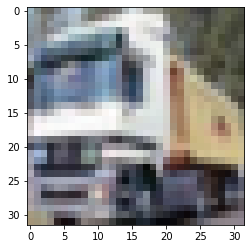

In [0]:
if __name__ == "__main__":
    cifar10 = CIFAR10()
    img = cifar10.x_train[1]
    plt.imshow(img)

In [0]:
def conv_block(X, num_filters, strides):
    
    x1 = Conv2D(num_filters, kernel_size=(3,3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(X)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(num_filters, kernel_size=(3,3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(num_filters, kernel_size=(3,3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(X)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(num_filters, kernel_size=(3,3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x = Add()([x1,x2])
    x = Activation('relu')(x)

    return x

In [0]:
def identity_block(X, num_filters):

    x1 = Conv2D(num_filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(X)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(num_filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(X)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(num_filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(X)
    x3 = BatchNormalization()(x3)
    x = Add()([x1, x2, x3])
    x = Activation('relu')(x)
    return x

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch >= 90:
        lr *= 1e-3
    elif epoch >= 70:
        lr *= 1e-2
    elif epoch >= 30:
        lr *= 1e-1
    return lr

In [0]:
def create_model(x):
    input_img = tf.keras.Input(shape=x.shape[1:])

    x = Conv2D(32, kernel_size=(7,7), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)

    x = conv_block(x, 64, (1,1))
    x = identity_block(x, 64)

    x = Dropout(0.1)(x)

    x = conv_block(x, 128, (1,1))

    x = identity_block(x, 128)

    x = Dropout(0.2)(x)

    x = conv_block(x, 256, (1,1))

    x = identity_block(x, 256)

    x = Dropout(0.2)(x)

    x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)

    x = Flatten()(x)
    y_pred = Dense(10, activation='softmax')(x)

    model = Model(inputs=[input_img], outputs=[y_pred])


    model.compile(
                  optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    
    return model

In [0]:
cifar = CIFAR10()
#cifar.data_augmentation(size=10000)
cifar.normalize_data()
x_train, y_train = cifar.get_train_set()
x_test, y_test = cifar.get_test_set()

lr_scheduler = LearningRateScheduler(lr_schedule)

model = create_model(x_train)

EPOCHS = 70
BATCH_SIZE = 128

training = model.fit(
                     x_train,
                     y_train,
                     batch_size=BATCH_SIZE, 
                     epochs=EPOCHS,
                     validation_data=(x_test, y_test),
                     callbacks=[lr_scheduler]
                    ) 

Epoch 1/70
391/391 [==============================] - 35s 88ms/step - loss: 1.9896 - accuracy: 0.5132 - val_loss: 2.0921 - val_accuracy: 0.4913 - lr: 0.0010
Epoch 2/70
391/391 [==============================] - 34s 86ms/step - loss: 1.4486 - accuracy: 0.6659 - val_loss: 1.5618 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 3/70
391/391 [==============================] - 34s 86ms/step - loss: 1.1907 - accuracy: 0.7239 - val_loss: 1.3456 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 4/70
391/391 [==============================] - 34s 86ms/step - loss: 1.0310 - accuracy: 0.7596 - val_loss: 1.1747 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 5/70
391/391 [==============================] - 34s 86ms/step - loss: 0.9239 - accuracy: 0.7812 - val_loss: 1.0646 - val_accuracy: 0.7355 - lr: 0.0010
Epoch 6/70
391/391 [==============================] - 34s 86ms/step - loss: 0.8584 - accuracy: 0.7962 - val_loss: 1.2584 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 7/70
391/391 [==============================] - 34s 

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
print("Test set result after whole training")
validation = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

Test set result after whole training
79/79 [==============================] - 2s 26ms/step - loss: 1.2650 - accuracy: 0.8469
